In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy import signal
from Audio_data import Audio_data
from Matrix_array import Matrix_array
from Audio_source import Audio_source
from Color_map import Color_map
import config

c = 340
# static_adaptive_array_config = {}


In [2]:
def antenna_setup():
    # r_a1, r_a2, r_a3, r_a4, uni_distance, row_elements, column_elements are user defined variables and can be in separate config file
    r_a1 = config.r_a1      # coordinate position of origin of array1
    r_a2 = config.r_a2      # coordinate position of origin of array2
    r_a3 = config.r_a3      # coordinate position of origin of array3
    r_a4 = config.r_a4      # coordinate position of origin of array4
    uni_distance = config.distance
    row_elements = config.rows
    column_elements = config.columns

    # array_matrix_1, array_matrix_2, array_matrix_3, array_matrix_4 below can be generated in parallell
    array_matrix_1 = Matrix_array(
        r_a1, uni_distance, row_elements, column_elements)
    # array_matrix_2 = Matrix_array(
    #     r_a2, uni_distance, row_elements, column_elements)
    # array_matrix_3 = Matrix_array(
    #     r_a3, uni_distance, row_elements, column_elements)
    # array_matrix_4 = Matrix_array(
    #     r_a4, uni_distance, row_elements, column_elements)

    # array_matrices contains the current active arrays that should be used (currently only array1 and array2)
    # array_matrices = np.array([array_matrix_1, array_matrix_2], dtype=object)
    array_matrices = np.array([array_matrix_1], dtype=object)

    # number of active sub_arrays, variable will be used in several for-loops etc.
    sub_arrays = len(array_matrices)

    # PLOT, only for visualization of array geometry
    for array in range(sub_arrays):
        plt.title('Array setup')
        plt.scatter(array_matrices[array].get_r_prime()[
                    0, :], array_matrices[array].get_r_prime()[1, :])
    plt.show()
    return array_matrices


In [3]:
def generate_array_signals(matrix_array, sources, t):
    # function that emulate signals for simulation

    r_prime = matrix_array.get_r_prime()
    Audio_signal = np.zeros((len(t), len(r_prime[0, :])))

    for sample in range(len(t)):
        if (sample+1 in np.linspace(0, len(t), 11)) or (sample == 0):
            print(sample+1)
        for mic in range(len(r_prime[0, :])):
            x_i = r_prime[0, mic]
            y_i = r_prime[1, mic]
            temp_signal_sample = 0
            for source in range(len(sources)):
                if (sources[source].get_t_start() < t[sample]) and (t[sample] < sources[source].get_t_end()):
                    frequencies_ps = sources[source].get_frequency()
                    theta_source = sources[source].get_theta()
                    phi_source = sources[source].get_phi()
                    rho_soruce = sources[source].get_rho()
                    for freq_ind in range(len(frequencies_ps)):
                        k = 2*math.pi*frequencies_ps[freq_ind]/c
                        r_1 = np.array([x_i, y_i, 0])
                        r_2 = rho_soruce * r_vec(theta_source, phi_source)
                        phase_offset = -k*np.linalg.norm(r_2-r_1)
                        element_amplitude = 1/np.linalg.norm(r_2-r_1)
                        temp_signal_sample += element_amplitude * \
                            math.sin(
                                2*math.pi * frequencies_ps[freq_ind] * t[sample] + phase_offset)
            Audio_signal[sample, mic] = temp_signal_sample
    return Audio_signal


In [4]:
def r_vec(theta, phi):
    return np.array([(math.sin(theta)*math.cos(phi)),
                 math.sin(theta)*math.sin(phi), math.cos(theta)])


In [5]:
def filtering(array_audio_signals, sub_arrays, frequency_bands, f_sampling, elements):
    audio_filtered_complete = np.zeros(
        (sub_arrays, len(frequency_bands)), dtype=object)
    filter_order = config.filter_order              # filter order
    # scale factor, making filter bandwidth more narrow
    scale_factor = config.scale_factor

    for array in range(sub_arrays):

        Audio_signal = array_audio_signals[array].get_audio_signals()

        calibration_weights = load_calibration_weights(
            array, elements, len(frequency_bands))  # calibration weights

        for freq_ind in range(len(frequency_bands)):
            # filter design for each band
            nu_0 = 2*frequency_bands[freq_ind] / \
                f_sampling   # normalized frequency
            cut_off = [nu_0 - nu_0/scale_factor, nu_0 + nu_0 /
                       scale_factor]  # cut-off frequency of filter
            # filter coefficients
            b = signal.firwin(filter_order, cut_off,
                              window="hamming", pass_zero=False)
            audio_temp = np.zeros((len(Audio_signal[:, 0]), elements))
            for mic_ind in range(elements):
                # apply filter on evert signal recorded from the elements
                audio_temp[:, mic_ind] = calibration_weights[freq_ind,
                                                             mic_ind] * signal.lfilter(b, 1.0, Audio_signal[:, mic_ind])

            audio_filtered_complete[array, freq_ind] = Audio_data(audio_temp)

            # plot all filters
            plt.figure(2)
            w, h = signal.freqz(b, worN=8000)
            H = 20*np.log10(abs(h))
            plt.plot((w/math.pi)*f_sampling/2, 20 *
                     np.log10(abs(h)), linewidth=2)
            plt.xlabel('Frequency (Hz)')
            plt.ylabel('Gain (dB)')
            plt.title('Frequency Response of all filters')
            plt.ylim(-5, 0.5)
            plt.xlim(70, f_sampling/2)
            plt.grid(True)

        print('Filtering of signals completed.')
    return audio_filtered_complete


In [6]:
def load_calibration_weights(array, elements, f_bands):
    # placeholder function, to be completed later
    # function should load calibration weights from file
    # returns matrix with calibration weights for all microphones, at all calibration frequencies
    # this can stored in a config file
    weights = np.ones((f_bands, elements))
    return weights


In [53]:
import multiprocessing
manager = multiprocessing.Manager()
return_queue = manager.dict()

def old_scanning(y_listen, x_listen, r_scan, frequency_bands, audio_filtered_complete, array_matrices, f_sampling, sub_arrays):
    # Scans for audio sources over the choosen scanning window, defined by y_listen, x_listen and r_scan

    # Initialize vector color_maps_complete, where all calculated color maps should be stored
    #   each element in color_maps_complete corresponds to a matrix color_map_new at a specific frequency
    #   each element in the matrix color_maps_new is a relative power value (color) in a specific direction
    color_maps_complete = np.zeros(len(frequency_bands), dtype=object)
    for freq_ind in range(len(frequency_bands)):
        color_map_new = np.zeros((len(y_listen), len(x_listen)))
        color_maps_complete[freq_ind] = Color_map(color_map_new)

    # To find audio sources, one needs to obtain the realtive power in a number of directions (coordinates)
    # number of directions = x_res*y_res
    # The directions are independent, so the signal processing in each direction can be done in parallell (the two following for-loops)
    for x_ind in range(len(x_listen)):
        print('\n x_ind: '+str(x_ind+1))                # print stuff for user
        x = x_listen[x_ind]                             # current x-coordinate
        print('\t y_ind:', end=' ')                     # print stuff for user
        for y_ind in range(len(y_listen)):
            print(str(y_ind+1), end=' ')                # print stuff for user
            y = y_listen[y_ind]                         # current y-coordinate
            z_0 = math.sqrt(r_scan**2 - x**2 - y**2)
            # get theta from our x,y coordinates
            theta = math.acos(z_0/r_scan)
            # get phi from our x,y coordinates
            phi = math.atan2(y, x)

            # The beam forming is performed independently in every frequency band, this can be done in parallell
            for freq_ind in range(len(frequency_bands)):
                # apply beamforming algo. in every frequency band
                # Perform the beamforming algoritm (phase-shift input signal according to listening direction of theta and phi)
                mic_data = beam_forming_algorithm(
                    audio_filtered_complete, array_matrices, theta, phi, frequency_bands[freq_ind], freq_ind, f_sampling)

                # obtain relative power (color) in the listening direction [theta, phi] at the frequency f=frequency_bands[freq_ind]
                color = sum(abs(mic_data)**2)

                # MIMO, save relative power (color) inte the direction [theta, phi] at frequency in matrix
                color_maps_complete[freq_ind].set_color(y_ind, x_ind, color)
    return color_maps_complete


def kernel(y_ind, x_ind, freq_ind, color_maps_complete, theta, phi, audio_filtered_complete, array_matrices, f_sampling, return_queue=None):
    mic_data = beam_forming_algorithm(
        audio_filtered_complete, array_matrices, theta, phi, frequency_bands[freq_ind], freq_ind, f_sampling)

    # obtain relative power (color) in the listening direction [theta, phi] at the frequency f=frequency_bands[freq_ind]
    color = sum(abs(mic_data)**2)

    # color_maps_complete[freq_ind].set_color(y_ind, x_ind, color)

    return_queue[y_ind, x_ind] = (color, freq_ind)


def scanning(y_listen, x_listen, r_scan, frequency_bands, audio_filtered_complete, array_matrices, f_sampling, sub_arrays):
    # Scans for audio sources over the choosen scanning window, defined by y_listen, x_listen and r_scan
    arjobs = []
    # Initialize vector color_maps_complete, where all calculated color maps should be stored
    #   each element in color_maps_complete corresponds to a matrix color_map_new at a specific frequency
    #   each element in the matrix color_maps_new is a relative power value (color) in a specific direction
    color_maps_complete = np.zeros(len(frequency_bands), dtype=object)
    for freq_ind in range(len(frequency_bands)):
        color_map_new = np.zeros((len(y_listen), len(x_listen)))
        color_maps_complete[freq_ind] = Color_map(color_map_new)

    for x_ind in range(len(x_listen)):
        print('\n x_ind: '+str(x_ind+1))                # print stuff for user
        x = x_listen[x_ind]                             # current x-coordinate
        print('\t y_ind:', end=' ')                     # print stuff for user
        for y_ind in range(len(y_listen)):
            print(str(y_ind+1), end=' ')                # print stuff for user
            y = y_listen[y_ind]                         # current y-coordinate
            z_0 = math.sqrt(r_scan**2 - x**2 - y**2)
            # get theta from our x,y coordinates
            theta = math.acos(z_0/r_scan)
            # get phi from our x,y coordinates
            phi = math.atan2(y, x)

            # The beam forming is performed independently in every frequency band, this can be done in parallell
            for freq_ind in range(len(frequency_bands)):
                arjobs.append((y_ind, x_ind, freq_ind, color_maps_complete, theta,
                              phi, audio_filtered_complete, array_matrices, f_sampling))

    jobs = []
    for work in arjobs:
        p = multiprocessing.Process(
            target=kernel, args=work, kwargs=dict(return_queue=return_queue))
        jobs.append(p)
        p.start()

    for proc in jobs:
        proc.join()

    # return color_maps_complete
    return return_queue





In [8]:
def listening(audio_filtered_complete, array_matrices, theta_listen, phi_listen, frequency_bands, f_sampling):
    samples = len(audio_filtered_complete[0, 0].get_audio_signals()[
                  :, 0])  # amount of samples of the audio tracks
    # initializing vector holding the audio output signal
    audio_out = np.zeros((samples))

    # convert listening angle from degrees in radians
    theta_rad = theta_listen*math.pi/180
    # convert listening angle from degrees in radians
    phi_rad = phi_listen*math.pi/180

    for freq_ind in range(len(frequency_bands)):
        # apply beamforming algo. in every frequency band
        # Perform the beamforming algoritm (phase-shift input signal according to listening direction of theta and phi)
        mic_signal = beam_forming_algorithm(
            audio_filtered_complete, array_matrices, theta_rad, phi_rad, frequency_bands[freq_ind], freq_ind, f_sampling)

        # MISO, summation of all mic_signals to one
        audio_out += mic_signal

    # scale audio signal
    audio_out = audio_out/max(audio_out)
    return audio_out


In [30]:
def beam_forming_algorithm(audio_filtered_complete, array_matrices, theta, phi, frequency, freq_ind, f_sampling):
    #
    #   IMPORTANT! The beamforming algorithm assumes the array matrices lies in the xy-plane
    #
    #   The beamforming algorithm calculates the necessary phase to introduce to the narrowband signal
    #   in order to have the maximum directivity in the direction r(theta,phi)
    #
    #   This phase-shift is introduced by a phase shifting function, which acts as a filter in time domain.
    #
    #   To improve performance, all elements of the array matrices are not in use. The user decides which
    #   element to use by sending in a weight vectir as a argument. The output signal is then normalized after
    #   how many elements where in use.

    samples = len(audio_filtered_complete[0, 0].get_audio_signals()[
                  :, 0])  # amount of samples of the audio tracks
    array_data = np.zeros((samples, 1))

    for array in range(len(array_matrices)):
        # Use the filtered audio signals
        audio_temp_signals = audio_filtered_complete[array, freq_ind].get_audio_signals(
        )

        #   The r_prime vector of the matrix array to know the location of every element, as well as how many
        #   elements exists.
        r_prime = array_matrices[array].get_r_prime()
        elements = array_matrices[array].get_elements()

        #   The narrowband wavevnumber
        k = 2*math.pi*frequency/c

        #   The normalized frequency
        ny = frequency/f_sampling

        #   Initialize output vector
        mic_data = np.zeros((samples, 1))

        #   The compensation factors to obtain uniform phase in the direction r_hat(theta,phi)
        x_factor = math.sin(theta)*math.cos(phi)
        y_factor = math.sin(theta)*math.sin(phi)

        # Adaptive configuration of the antanna array
        # adaptive_weight = adaptive_array_config(
        #     array_matrices[array], frequency)
        adaptive_weight = static_array_config[frequency]

        # print(adaptive_weight)

        for mic_ind in range(elements):
            #   calculate the narrowband phase-shift
            phase_shift_value = -k * \
                (r_prime[0, mic_ind] * x_factor + r_prime[1, mic_ind]*y_factor)

            #   Sum the individually shifted data from the atnenna elements as well as weight them with
            #   appropriate weight.
            mic_data += adaptive_weight[0, mic_ind] * phase_shift(
                audio_temp_signals[:, mic_ind], ny, phase_shift_value)

        norm_coeff = 1/sum(adaptive_weight[0])
        mic_data = mic_data * norm_coeff

        array_data += mic_data

    return array_data


In [10]:
def static_adaptive_array_config(row_elements, column_elements, uni_distance, frequency):

    wavelength = c/frequency                    # wavelength of signal
    # relative wavelenght to distance between microphone elements
    wavelength_rel = uni_distance/wavelength

    if wavelength_rel > 0.1581:
        # mode 1
        weight = np.ones((1, row_elements*column_elements))
        return weight
    elif (wavelength_rel <= 0.156) and (wavelength_rel > 0.0986):
        mode = 3
    elif (wavelength_rel <= 0.0986) and (wavelength_rel > 0.085):
        mode = 5
    elif (wavelength_rel <= 0.085) and (wavelength_rel > 0.07):
        mode = 6
    else:
        mode = 7

    weight = np.zeros((1, row_elements*column_elements))
    row_lim = math.ceil(row_elements/mode)
    column_lim = math.ceil(column_elements/mode)
    for i in range(row_lim):
        for j in range(column_lim):
            # this calculation could be wrong thanks to matlab and python index :))
            element_index = (mode*i*row_elements + mode*j)
            weight[0, element_index] = 1
    return weight


In [32]:
def phase_shift(x, ny, phase):
    # Phase shifts the input signal
    #
    #   Input signal x
    #
    #   Output signal y
    #
    #   if x = cos(n*2*pi*ny), then y = cos(n*2*pi*ny + phase)
    #
    x_length = len(x)
    # y = np.zeros((x_length, 1))

    # for i in range(x_length-1):
    #     y[i] = math.cos(phase) * x[i] + math.sin(phase) / \
    #         (2*math.pi*ny)*(x[i+1]/2 - x[i-1]/2)

    # return y

    return np.array(([math.cos(phase) * x[i] + math.sin(phase) /
                      (2*math.pi*ny)*(x[i+1]/2 - x[i-1]/2) for i in range(len(x)-1)], 1))


In [12]:
def validation_check(y_listen, x_listen, sources, r_scan):
    # Validation check
    xy_val_check = np.zeros((len(y_listen), len(x_listen)))
    for x_ind in range(len(x_listen)):
        x = x_listen[x_ind]
        for y_ind in range(len(y_listen)):
            y = y_listen[y_ind]
            temp_val = 0
            for source_ind in range(len(sources)):
                x_s = r_scan * \
                    math.sin(sources[source_ind].get_theta()) * \
                    math.cos(sources[source_ind].get_phi())
                y_s = r_scan * \
                    math.sin(sources[source_ind].get_theta()) * \
                    math.sin(sources[source_ind].get_phi())
                temp_val += 1/math.sqrt(((x_s - x)**2 + (y_s - y)**2))
            xy_val_check[y_ind, x_ind] = temp_val

    plt.figure(3)
    plt.imshow(xy_val_check, extent=extents(x_listen) +
               extents(y_listen), origin='lower')
    plt.title('Actual location of sources')


def show_beamforming_results(y_listen, x_listen, frequency_bands, color_maps):
    # calculate total intensity at all frequencies, and show results of beamforming
    color_map_intensity = np.zeros((len(y_listen), len(x_listen)))
    for freq_ind in range(len(frequency_bands)):
        color_map_intensity += color_maps[freq_ind].get_color_data_matrix()
    plt.figure(4)
    plt.imshow(color_map_intensity, extent=extents(
        x_listen) + extents(y_listen), origin='lower')
    plt.title('Beamforming results')
    return color_map_intensity


def extents(f):
    # function to show images with correct axis values (with plt.imshow()), corresponding to our scanning window
    delta = f[1]-f[0]
    return [f[0] - delta/2, f[-1] + delta/2]


In [13]:
def maximum_intensity(color_maps_complete, frequency_bands):
    # Get maximum intensity of a signals, at any frequency
    max_intensity = 0
    for freq_ind in range(len(frequency_bands)):
        intensity = np.max(
            np.max(color_maps_complete[freq_ind].get_color_data_matrix()))
        if intensity > max_intensity:
            max_intensity = intensity
    return max_intensity


In [39]:
source1 = Audio_source(config.f_start1, config.f_end1, config.f_res1,
                       config.theta_deg1, config.phi_deg1, config.away_distance, config.t_start1, config.t_end1)
source2 = Audio_source(config.f_start2, config.f_end2, config.f_res2,
                       config.theta_deg2, config.phi_deg2, config.away_distance, config.t_start2, config.t_end2)
sources = np.array([source1, source2])


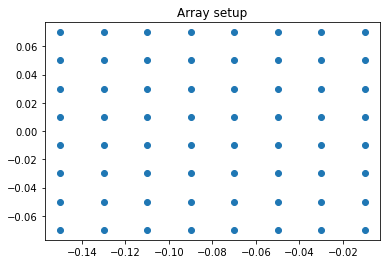

Loading from Memory: array_audio_signals.npy
Filtering of signals completed.

 x_ind: 1
	 y_ind: 1 2 3 4 5 6 7 8 9 10 
 x_ind: 2
	 y_ind: 1 2 3 4 5 6 7 8 9 10 
 x_ind: 3
	 y_ind: 1 2 3 4 5 6 7 8 9 10 
 x_ind: 4
	 y_ind: 1 2 3 4 5 6 7 8 9 10 
 x_ind: 5
	 y_ind: 1 2 3 4 5 6 7 8 9 10 
 x_ind: 6
	 y_ind: 1 2 3 4 5 6 7 8 9 10 
 x_ind: 7
	 y_ind: 1 2 3 4 5 6 7 8 9 10 
 x_ind: 8
	 y_ind: 1 2 3 4 5 6 7 8 9 10 
 x_ind: 9
	 y_ind: 1 2 3 4 5 6 7 8 9 10 
 x_ind: 10
	 y_ind: 1 2 3 4 5 6 7 8 9 10 

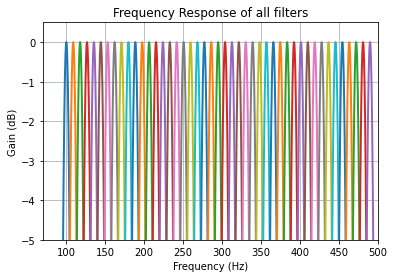

In [42]:
def main():
    # Initialization
    # f_sampling, t_start, t_end, away_distance are user defined variables
    f_sampling = config.f_sampling                      # sampling frequency in Hz
    t_start = config.t_start                            # start time of simulation
    t_end = config.t_end                                # end time of simulation
    t_total = t_end - t_start                           # total simulation time
    t = np.linspace(t_start, t_end, t_total*f_sampling)  # time vector

    # Set up array antenna
    array_matrices = antenna_setup()
    sub_arrays = len(array_matrices)

    filename = "array_audio_signals.npy"

    source1 = Audio_source(config.f_start1, config.f_end1, config.f_res1,
                           config.theta_deg1, config.phi_deg1, config.away_distance, config.t_start1, config.t_end1)


    source2 = Audio_source(config.f_start2, config.f_end2, config.f_res2,
                        config.theta_deg2, config.phi_deg2, config.away_distance, config.t_start2, config.t_end2)
    sources = np.array([source1, source2])
    

    try:
        # array_audio_signals = np.load(filename)
        array_audio_signals = np.load(filename, allow_pickle=True)
        print("Loading from Memory: " + filename)
    except:
        print("Creating data")

        # Create and place out sources
        # source1 and source2 below can be generated in parallell
        source1 = Audio_source(config.f_start1, config.f_end1, config.f_res1,
                            config.theta_deg1, config.phi_deg1, config.away_distance, config.t_start1, config.t_end1)
        source2 = Audio_source(config.f_start2, config.f_end2, config.f_res2,
                            config.theta_deg2, config.phi_deg2, config.away_distance, config.t_start2, config.t_end2)
        sources = np.array([source1, source2])
        
        # GENERATE AUDIO SIGNAL
        # will only be used to emulate data, this will not be used when the algoritm runs with real data
        array_audio_signals = np.zeros((sub_arrays), dtype=object)
        print('Number of samples generated (of '+str(f_sampling*t_total)+'):')
        for array in range(sub_arrays):  # PARALLELL
            # generate the audio signals on each array-element for each sub-array
            temp_signal = generate_array_signals(array_matrices[array], sources, t)
            array_audio_signals[array] = Audio_data(temp_signal)
            print('Audio signal for array '+str(array+1)+' generated')

        np.save(filename, array_audio_signals)

    # --- SIGNAL PROCESSING/BEAMFORMING ON SIGNALS STARTS HERE ---
    x_res = config.x_res                # resolution in x of scanning window
    y_res = config.y_res                # resolution in y of scanning window
    x_listen = np.linspace(-1, 1, x_res)  # scanning window, x coordinates
    y_listen = np.linspace(-1, 1, y_res)  # scanning window, y coordinates
    # radius of our scanning window, r_scan² = x²+y²+z²
    r_scan = math.sqrt(2)

    f_bands_N = config.f_bands_N        # number of frequency bands
    bandwidth = config.bandwidth        # bandwidth of incoming audio signal
    # vector holding center frequencies of all frequency bands
    frequency_bands = np.linspace(bandwidth[0], bandwidth[1], f_bands_N)
    samples = len(t)

    # for freq in frequency_bands:
    global static_array_config
    static_array_config = {freq:static_adaptive_array_config(
        8, 8, 2e-2, freq) for freq in frequency_bands}  # 8, 8, 2e-2 should be variables

    # FILTERING
    audio_filtered_complete = filtering(
        array_audio_signals, sub_arrays, frequency_bands, f_sampling, array_matrices[0].get_elements())

    # SCANNING, start scanning after sources, at all different angles
    intensity_maps = scanning(y_listen, x_listen, r_scan, frequency_bands,
                              audio_filtered_complete, array_matrices, f_sampling, sub_arrays)

    return intensity_maps
    # VALIDATION CHECK, check where the source is actually located
    validation_check(y_listen, x_listen, sources, r_scan)

    # calculate maximum obtained intensity
    # not sure if this will be used in the final signal processing algorithm
    max_intensity = maximum_intensity(intensity_maps, frequency_bands)

    # "HEAT MAP"
    # calculate total intensity at all frequencies, and show results of beamforming (as a heat map)
    total_intensity = show_beamforming_results(
        y_listen, x_listen, frequency_bands, intensity_maps)

    # show all plots
    plt.show()





















# Warning, incomplete data (Not correctly gathered after Multiprocessing)


intensity_maps = main()


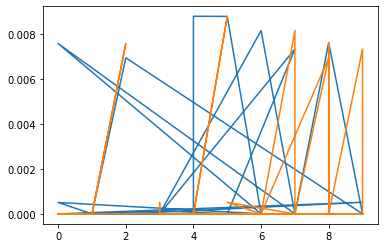

In [56]:
b = dict(intensity_maps)
# b.values()
plt.plot(b.keys(), b.values())
# len(b[0, 0])



# for i in dict(intensity_maps):
#     k = intensity_maps[i]
#     print(k)


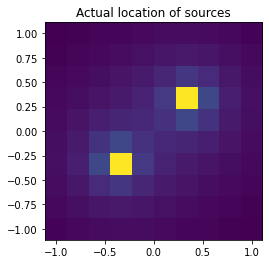

In [35]:

x_res = config.x_res                # resolution in x of scanning window
y_res = config.y_res                # resolution in y of scanning window
x_listen = np.linspace(-1, 1, x_res)  # scanning window, x coordinates
y_listen = np.linspace(-1, 1, y_res)  # scanning window, y coordinates
# radius of our scanning window, r_scan² = x²+y²+z²
r_scan = math.sqrt(2)

f_bands_N = config.f_bands_N        # number of frequency bands
bandwidth = config.bandwidth        # bandwidth of incoming audio signal
# vector holding center frequencies of all frequency bands
frequency_bands = np.linspace(bandwidth[0], bandwidth[1], f_bands_N)


# VALIDATION CHECK, check where the source is actually located
validation_check(y_listen, x_listen, sources, r_scan)

# calculate maximum obtained intensity
# not sure if this will be used in the final signal processing algorithm
# max_intensity = maximum_intensity(intensity_maps, frequency_bands)

# # "HEAT MAP"
# # calculate total intensity at all frequencies, and show results of beamforming (as a heat map)
# total_intensity = show_beamforming_results(
#     y_listen, x_listen, frequency_bands, intensity_maps)

# show all plots
plt.show()
